In [3]:
from pathlib import Path
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
from time import time

%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING) 

In [4]:
datapath = Path('/data/users/tch14/slurm_runs/')
runs = sorted((f.stat().st_mtime,f) for f in datapath.iterdir() if not f.name.startswith('.'))
runs

[(1565015458.1930864, PosixPath('/data/users/tch14/slurm_runs/89172')),
 (1565019666.7720778, PosixPath('/data/users/tch14/slurm_runs/89173')),
 (1565091786.8295145, PosixPath('/data/users/tch14/slurm_runs/89383')),
 (1568281592.049746, PosixPath('/data/users/tch14/slurm_runs/92868')),
 (1568288436.158248, PosixPath('/data/users/tch14/slurm_runs/92931')),
 (1568309946.764264, PosixPath('/data/users/tch14/slurm_runs/93435')),
 (1568371709.8116553, PosixPath('/data/users/tch14/slurm_runs/93943')),
 (1568378794.6601355, PosixPath('/data/users/tch14/slurm_runs/94443')),
 (1568648943.719887, PosixPath('/data/users/tch14/slurm_runs/94948')),
 (1569249486.5304642, PosixPath('/data/users/tch14/slurm_runs/95035'))]

In [5]:
from operator import mul
from functools import reduce
def product(iterable): return reduce(mul, iterable)

from munch import Munch

def get_data(this_run,
            observable_names = ['Ff', 'Fc', 'Mf_moments'],
            temp_slice = slice(None,None,1),
            MCMC_slice = slice(None,None,1),
            ):
    print(f'looking in {this_run}')
    datafiles = sorted([(int(f.stem), f) for f in this_run.iterdir() if f.name.endswith('npz') and not f.name == 'parameters.npz'])
    jobs = np.array([j_id for j_id, f in datafiles])
    print(f'job ids range from {min(jobs)} to {max(jobs)}')
    print(f'missing jobs: {set(range(max(jobs))) - set(jobs)}\n')
    
    d = np.load(datafiles[0][1], allow_pickle = True)
    Ts = d['Ts']
    parameters = d['parameters'][()]
    MCMC_params = d['MCMC_params'][()]
    
    print('keys: ', list(d.keys()), '\n')
    print('MCMC_params: ', MCMC_params, '\n')
    
    original_N_steps = MCMC_params['N_steps']
    thin = MCMC_params['thin']
    N_steps = original_N_steps // thin
    print(f'MCMC Steps: {original_N_steps} with thinning = {thin} for {N_steps} recorded steps')
    print(f'Slicing this with MCMC_slice = {MCMC_slice}\n')
    
    N_Ts = len(Ts)
    T = Ts[temp_slice]

    print(f'T has (min, max, len) = {[f(Ts) for f in [min, max, len]]}, slicing by {temp_slice} to get {[f(T) for f in [min, max, len]]}\n')

    print('Allocating space for the requested observables:')
    observables = Munch()
    for name in observable_names:
        src = getattr(d['logs'][0], name)
        shape = (len(T),) + src[..., MCMC_slice].shape
        approx_size = 4*product(shape)
        assert(approx_size < 1e9) #try not to use more than 1Gb per allocation
        observables[name] = np.zeros(shape, dtype = src.dtype)
        print(f"observables['{name}'] = np.array(shape = {shape}, dtype = {src.dtype}) approx size: {approx_size/1e9:.2f}Gb")

    print('Copying the data')
    t0 = time()
    dot_batch = len(T) // 50 if len(T) > 50 else 1
    for j, (n,file) in enumerate(datafiles[temp_slice]):
        npz_file = np.load(file, allow_pickle = True)['logs'][0]
        if j == 10: print(f'Took {time() - t0:.2f}s to do the first 10, should take {(len(T)-10)*(time() - t0):.2f}s to do the remaining {len(T) - 10}')
        if j % dot_batch == 0: print(f'{n} ', end='')
        
        for name in observable_names:
            observables[name][j] = getattr(npz_file, name)[..., MCMC_slice]
    print('')
    print('########################################################################\n')
    observables['T'] = T
    observables.update({k : v[()] for k,v in d.items() if k != 'logs'})
    print(f'Observables has keys: {observables.keys()}')
    
    return observables
    
def get_data_2(this_run,
            observable_names = ['Ff', 'Fc', 'Mf_moments', 'time'],
            temp_slice = slice(None,None,1),
            MCMC_slice = slice(None,None,1),
            ):
    print(f'looking in {this_run}')
    datafiles = sorted([(int(f.stem), f) for f in this_run.iterdir() if f.name.endswith('npz') and not f.name == 'parameters.npz'])
    jobs = np.array([j_id for j_id, f in datafiles])
    print(f'job ids range from {min(jobs)} to {max(jobs)}')
    print(f'missing jobs: {set(range(max(jobs))) - set(jobs)}\n')
    
    d = np.load(datafiles[0][1], allow_pickle = True)
    Ts = d['Ts']
    Ns = d['Ns']
    parameters = d['parameters'][()]
    MCMC_params = d['MCMC_params'][()]
    
    
    print('keys: ', list(d.keys()), '\n')
    print('MCMC_params: ', MCMC_params, '\n')
    
    original_N_steps = MCMC_params['N_steps']
    thin = MCMC_params['thin']
    N_steps = original_N_steps // thin
    print(f'MCMC Steps: {original_N_steps} with thinning = {thin} for {N_steps} recorded steps')
    print(f'Slicing this with MCMC_slice = {MCMC_slice}\n')
    
    N_Ts = len(Ts)
    T = Ts[temp_slice]
    
    print(f'T has (min, max, len) = {[f(Ts) for f in [min, max, len]]}, slicing by {temp_slice} to get {[f(T) for f in [min, max, len]]}\n')

    possible_observables = [s for s in dir(d["logs"][0]) if not s.startswith("_")]
    print(f'dir(d["logs"][0]) = {possible_observables}')
    print(f'Allocating space for the requested observables {observable_names}:')
    observables = Munch()
    for name in observable_names:
        src = getattr(d['logs'][0], name)
        if type(src) == np.ndarray: 
            shape = (len(Ns), len(T),) + src[..., MCMC_slice].shape
        elif type(src) == float:
            src = np.array(src)
            shape = (len(Ns), len(T),)
        else:
            raise ValueError(f'Not sure what to do with {src}')
            
        
        print(name, shape)
        approx_size = 4*product(shape) #assumes 64bit floats
        assert(approx_size < 1e9) #try not to use more than 1Gb per allocation
        observables[name] = np.zeros(shape, dtype = src.dtype)
        print(f"observables['{name}'] = np.array(shape = {shape}, dtype = {src.dtype}) approx size: {approx_size/1e9:.2f}Gb")

    print('Copying the data')
    t0 = time()
    dot_batch = len(T) // 50 if len(T) > 50 else 1
    for j, (n,file) in enumerate(datafiles[temp_slice]):
        npz_file = np.load(file, allow_pickle = True)['logs']
        if (j == 10) or (j == len(T)//2): 
            dt = time() - t0
            print(f'\nTook {dt:.2f}s to do the first {j}, should take {(len(T)-j)*dt/j:.2f}s to do the remaining {len(T) - j}\n')
        if j % dot_batch == 0: print(f'{n} ', end='')
        for name in observable_names:
            for i in range(len(Ns)):
                obs = getattr(npz_file[i], name)
                if type(obs) == np.ndarray:
                    observables[name][i, j] = obs[..., MCMC_slice]
                elif type(obs) == float:
                    observables[name][i, j] = obs
                else:
                    raise ValueError(f'Not sure what to do with {obs}')
    print('')
    print('########################################################################\n')
    observables['T'] = T
    observables.update({k : v[()] for k,v in d.items() if k != 'logs'})
    print(f'Observables has keys: {observables.keys()}')
    
    return observables
   
    
obs1 = get_data(Path('/data/users/tch14/slurm_runs/92931'), temp_slice = slice(0,500,50), MCMC_slice = slice(None,None,100))
obs2 = get_data(Path('/data/users/tch14/slurm_runs/93435'))
obs3 = get_data(Path('/data/users/tch14/slurm_runs/94443'))

looking in /data/users/tch14/slurm_runs/92931
job ids range from 0 to 499
missing jobs: set()

keys:  ['Ns', 'Ts', 'parameters', 'MCMC_params', 'logs', 'desc'] 

MCMC_params:  {'state': '...', 'N_steps': 100000, 'N_burn_in': 10000, 'thin': 1, 'logger': <FKMC.montecarlo.Eigenspectrum_IPR_all object at 0x7f1fd5772160>, 'proposal': <function p_multi_site_uniform_reflect at 0x7f1fc8c92ea0>, 'accept_function': <function perturbation_accept at 0x7f1fc8c94268>, 'warnings': True} 

MCMC Steps: 100000 with thinning = 1 for 100000 recorded steps
Slicing this with MCMC_slice = slice(None, None, 100)

T has (min, max, len) = [0.5, 1.5, 500], slicing by slice(0, 500, 50) to get [0.5, 1.4018036072144286, 10]

Allocating space for the requested observables:
observables['Ff'] = np.array(shape = (10, 1000), dtype = float64) approx size: 0.00Gb
observables['Fc'] = np.array(shape = (10, 1000), dtype = float64) approx size: 0.00Gb
observables['Mf_moments'] = np.array(shape = (10, 5, 1000), dtype = float64

In [65]:
obs4 = get_data(Path('/data/users/tch14/slurm_runs/94948'), temp_slice = slice(0,85,1))

looking in /data/users/tch14/slurm_runs/94948
job ids range from 0 to 85
missing jobs: set()

keys:  ['Ns', 'Ts', 'parameters', 'MCMC_params', 'logs', 'desc'] 

MCMC_params:  {'state': '...', 'N_steps': 1000000, 'N_burn_in': 10000, 'thin': 1000, 'logger': <FKMC.montecarlo.Eigenspectrum_IPR_all object at 0x7f665b5730b8>, 'proposal': <function p_multi_site_uniform_reflect at 0x7f665c9c18c8>, 'accept_function': <function perturbation_accept at 0x7f665c9c1bf8>, 'warnings': True} 

MCMC Steps: 1000000 with thinning = 1000 for 1000 recorded steps
Slicing this with MCMC_slice = slice(None, None, 1)

T has (min, max, len) = [0.9008016, 1.49599198, 100], slicing by slice(0, 85, 1) to get [0.9008016, 1.40581162, 85]

Allocating space for the requested observables:
observables['Ff'] = np.array(shape = (85, 1000), dtype = float64) approx size: 0.00Gb
observables['Fc'] = np.array(shape = (85, 1000), dtype = float64) approx size: 0.00Gb
observables['Mf_moments'] = np.array(shape = (85, 5, 1000), dty

In [6]:
obs1.parameters

{'t': 1,
 'alpha': 1.5,
 'mu': 0,
 'beta': 2.0,
 'J': 5,
 'U': 5,
 'normalise': True,
 'J_matrix': '...'}

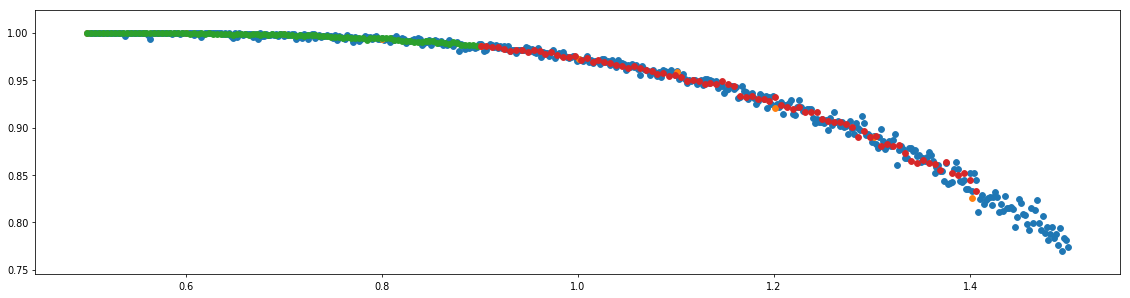

In [66]:
f, ax = plt.subplots(figsize = (20,5))
for obs in [obs2, obs1, obs3, obs4]:
    ax.scatter(obs.T, obs.Mf_moments[:, 2].mean(axis=-1))

In [125]:
o = obs4.T
(max(o) - min(o)) / len(o)
1/0.005

200.0

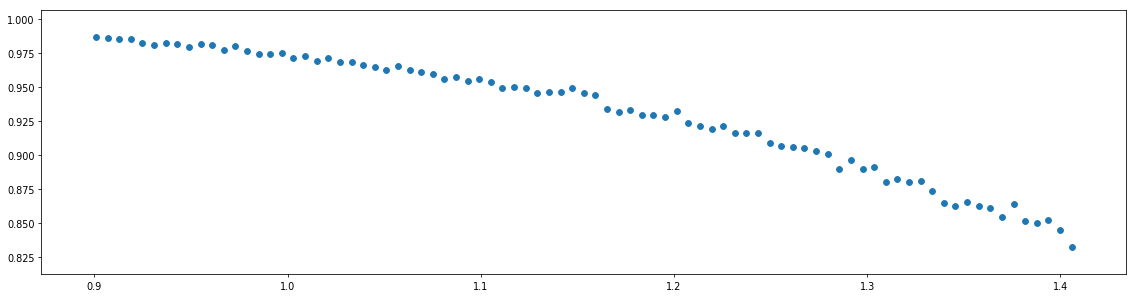

In [68]:
f, ax = plt.subplots(figsize = (20,5))
for obs in [obs4]:
    ax.scatter(obs.T, obs.Mf_moments[:, 2].mean(axis=-1))
    
#ax.set(xlim = (0.7,1), ylim = (0.95, 1.1))

(17,) (17,) (17, 1000) (17, 1000)


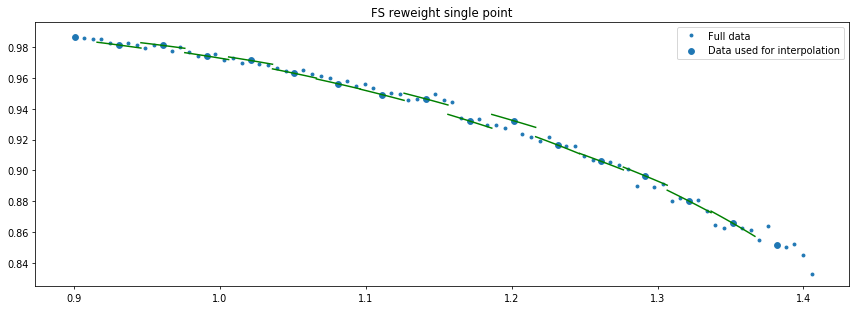

In [85]:
def FS_reweight(betas, beta, Fs, Os):
    '''Takes data at a single temperature beta and extrapolates it to a new grid called betas'''
    exp_arg = -(betas[:, None] - beta) * Fs[None, :]
    #exp_arg -= np.max(exp_arg)
    boltz_factors = np.exp(exp_arg)
    return np.sum(boltz_factors * Os, axis = -1) / np.sum(boltz_factors, axis = -1)

def interp(Ts, Fs, Os, ax):
    for i in range(len(Ts))[1:-1]:
        l_T = (Ts[i-1] + Ts[i]) / 2
        h_T = (Ts[i] + Ts[i+1]) / 2
        new_Ts = np.linspace(l_T, h_T, 10)

        reweighted_O = FS_reweight(betas = 1/new_Ts, beta = 1/Ts[i], Fs = Fs[i], Os = Os[i])

        ax.plot(new_Ts, reweighted_O, color = 'g')
        
        
i = slice(None, None, 5)        
obs = obs4
T = obs.T[i]
Fs = obs.Ff[i] + obs.Fc[i]
Os = obs.Mf_moments[i, 2, :]

y = Os.mean(axis = -1)
yerr = Os.std(axis = -1)
print(y.shape, T.shape, Os.shape, Fs.shape)


f, ax = plt.subplots(1, figsize = (15,5))
ax.plot(obs.T, obs.Mf_moments[:, 2].mean(axis=-1), '.', label = 'Full data')
ax.scatter(T, y, marker = 'o', label = 'Data used for interpolation')

ax.set(
    title = 'FS reweight single point',
    #xlim = (1,3),
    )

interp(T, Fs, Os, ax)
        
ax.legend()

In [115]:
from math import ceil
m = 5
print(m//2)
np.arange(-(m//2), (m//2) + 1, 1) 

2


array([-2, -1,  0,  1,  2])

In [7]:
def new_fs(new_betas, Fs, betas, fs):
    #new_beta: the betas we want to interpolate to
    #betas: the set of temperatures at which the mcmc runs were performed
    #Fs.shape = (number of runs, number of step)
    #fs.shape = (number of runs), this need to be determined self consistently
    #final shapes: [new_beta index, runs over mcmc runs, runs over steps in an mcmc run, runs over runs again for innnermost sum]
    betas = betas[None, None, None, :]
    Fs3 = Fs[None, :, :]
    Fs4 = Fs[None, :, :, None]
    new_betas = new_betas[:, None, None]
    fs = fs[None, None, None, :]
    
    A = np.exp(- new_betas * Fs3) / np.sum(np.exp(- betas * Fs4 + fs), axis = -1)
    expf = 1/Fs.shape[1] * np.sum(A, axis = (1,2))
    return - np.log(expf)

from scipy.optimize import fixed_point
def fit_fs(Fs, betas, fs_guess):
    def func(fs): 
        if np.any(np.isnan(fs)): raise RuntimeError('The iteration hit a nan')
        return new_fs(betas, Fs, betas, fs)
    fs = fixed_point(func, fs_guess, maxiter=1000)
    return fs

def FS_multi_reweight(new_betas, Os, Fs, betas, fs_guess = None):
    #print(' '.join(f'{key} = {val.shape}' for key, val in locals().items()))
    fs_guess = fs_guess if not fs_guess is None else np.zeros_like(betas)
    fs = fit_fs(Fs, betas, fs_guess)
    print(fs)
    
    the_new_fs = new_fs(new_betas, Fs, betas, fs)[:, None, None]
    new_betas = new_betas[:, None, None]
    Fs3 = Fs[None, :, :]
    
    betas = betas[None, None, None, :]
    fs = fs[None, None, None, :]
    Fs4 = Fs[None, :, :, None]
    
    O = Os * np.exp(- new_betas * Fs3 + the_new_fs) / np.sum(np.exp(- betas * Fs4 + fs), axis = -1)
    
    return 1/Fs.shape[1] * np.sum(O, axis = (1,2)), fs[0,0,0,:]

def interp_multi(Ts, Fs, Os, ax, m = 3):
    fs_guess = None
    grid = np.arange(-(m//2), (m//2) + 1, 1) #[-1,0,1], [-2,-1,0,1,2] etc
    for i in range(len(Ts))[m//2:-(m//2)]:
        try:
            ix = i + grid 
            new_Ts = np.linspace((Ts[i-1]+Ts[i])/2,(Ts[i]+Ts[i+1])/2, 10)

            reweighted_O, fs = FS_multi_reweight(new_betas = 1/new_Ts, betas = 1/Ts[ix], Fs = Fs[ix], Os = Os[ix])

            ax.plot(new_Ts, reweighted_O, color = 'r')
        except RuntimeError:
            pass
                       
i = slice(None, None, 4)        
obs = obs4
T = obs.T[i]
Fs = obs.Ff[i] + obs.Fc[i]
Os = obs.Mf_moments[i, 2, :]

y = Os.mean(axis = -1)
yerr = Os.std(axis = -1)

f, ax = plt.subplots(1, figsize = (15,5))

ax.plot(obs.T, obs.Mf_moments[:, 2].mean(axis=-1), '.', label = 'Full data')
ax.scatter(T, y, marker = 'o', label = 'Data used for interpolation')

ax.set(
    title = 'FS reweight single point',
    #xlim = (1,1.2),
    )
interp_multi(T, Fs, Os, ax)

NameError: name 'obs4' is not defined

In [180]:
from FKMC.stats import autocorrelation

obs1 = get_data(Path('/data/users/tch14/slurm_runs/92931'), temp_slice = slice(50,None,1), MCMC_slice = slice(None,None,10))

looking in /data/users/tch14/slurm_runs/92931
job ids range from 0 to 499
missing jobs: set()

keys:  ['Ns', 'Ts', 'parameters', 'MCMC_params', 'logs', 'desc'] 

MCMC_params:  {'state': '...', 'N_steps': 100000, 'N_burn_in': 10000, 'thin': 1, 'logger': <FKMC.montecarlo.Eigenspectrum_IPR_all object at 0x7f666a1493c8>, 'proposal': <function p_multi_site_uniform_reflect at 0x7f665c9c18c8>, 'accept_function': <function perturbation_accept at 0x7f665c9c1bf8>, 'warnings': True} 

MCMC Steps: 100000 with thinning = 1 for 100000 recorded steps
Slicing this with MCMC_slice = slice(None, None, 10)

T has (min, max, len) = [0.5, 1.5, 500], slicing by slice(50, None, 1) to get [0.6002004008016032, 1.5, 450]

Allocating space for the requested observables:
observables['Ff'] = np.array(shape = (450, 10000), dtype = float64) approx size: 0.02Gb
observables['Fc'] = np.array(shape = (450, 10000), dtype = float64) approx size: 0.02Gb
observables['Mf_moments'] = np.array(shape = (450, 5, 10000), dtype = 

6.414014547335464


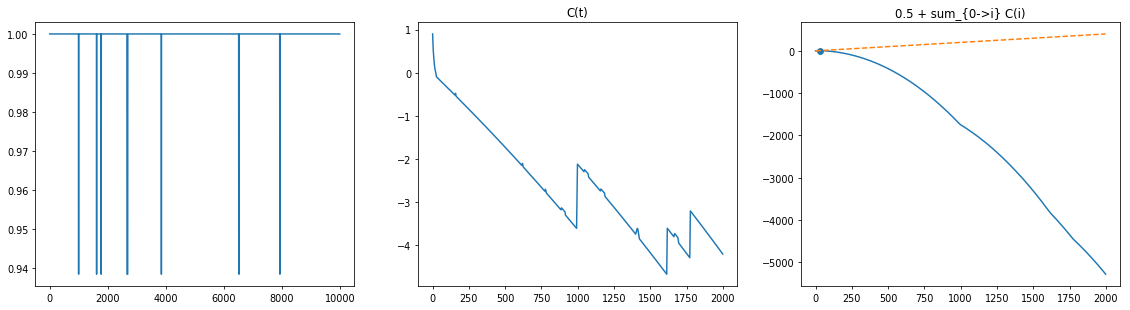

In [182]:
y = obs1.Mf_moments[3, 2, :]
Cs = autocorrelation(y)[:y.shape[0]//5]
ts = np.arange(Cs.shape[0])

f ,axes = plt.subplots(1,3, figsize = (20,5))
axes[0].plot(y)

axes[1].plot(ts, Cs)
axes[1].set(title = 'C(t)')

taus = 1/2 + np.cumsum(Cs)
axes[2].plot(ts, taus)
axes[2].set(title = '0.5 + sum_{0->i} C(i)',
            #ylim = (min(taus), max(taus))
           )
axes[2].plot(ts,ts/5,'--')

crossings = np.argwhere(np.diff(np.sign(ts/5 - taus))).flatten()
axes[2].scatter(ts[crossings], taus[crossings])

def series_tau(X):
    Cs = autocorrelation(X)
    ts = np.arange(Cs.shape[0])
    taus = 1/2 + np.cumsum(Cs)
    
    crossings = np.argwhere(np.diff(np.sign(ts/5 - taus))).flatten()
    if len(crossings) < 1:
        return np.nan
    return taus[crossings[0]]

print(series_tau(y))

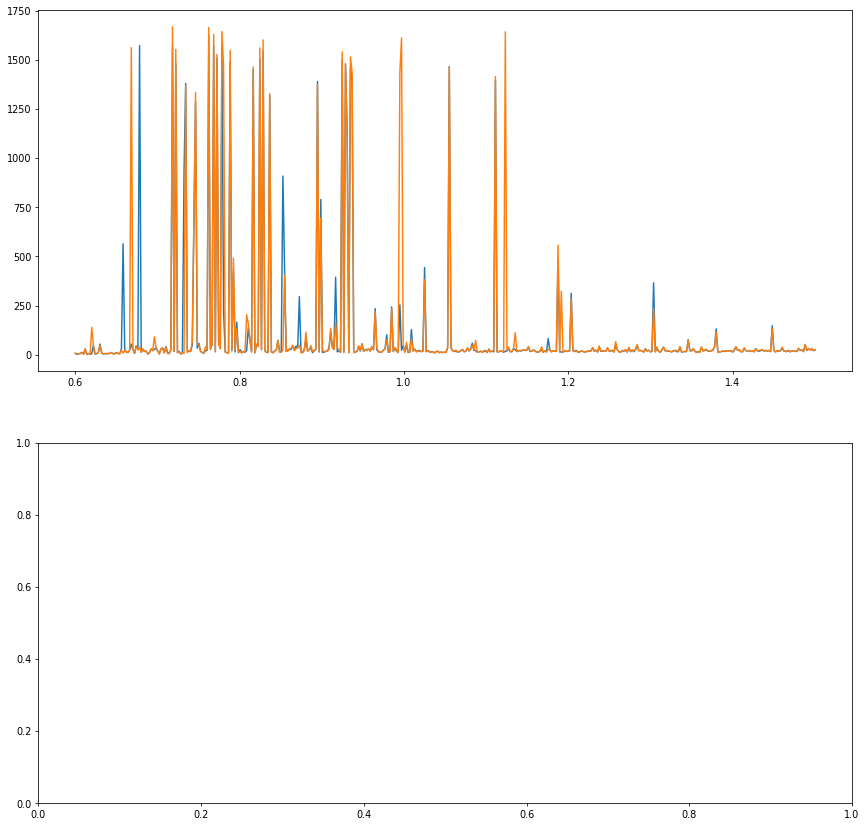

In [187]:
f, axes = plt.subplots(2,1, figsize = (15,15))

taus = np.array([series_tau(y) for y in obs1.Mf_moments[:, 2, :]])
tausbyten = 10*np.array([series_tau(y) for y in obs1.Mf_moments[:, 2, ::10]])
axes[0].plot(obs1.T, taus)
axes[0].plot(obs1.T, tausbyten)

(1000,) (200,)


/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)


1.693363671474206

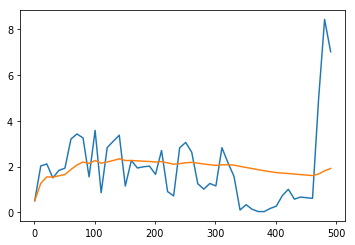

In [140]:
from FKMC.stats import bin_std, bin_estimate_tau
from FKMC.general import running_mean
    
bins = np.arange(1,1000,10)
errs = np.array([bin_std(y, i) for i in bins])
sigma_naive = y.std()

taus = y.shape[0] / 2 * (errs / sigma_naive)**2

f ,ax = plt.subplots()
ax.plot(bins, taus)
print(y.shape, taus.shape)
ax.plot(bins, running_mean(taus))


bin_estimate_tau(y, binsize = 50, max_its = 10, binsize_multiplier = 5)

NameError: name 'Ns' is not defined

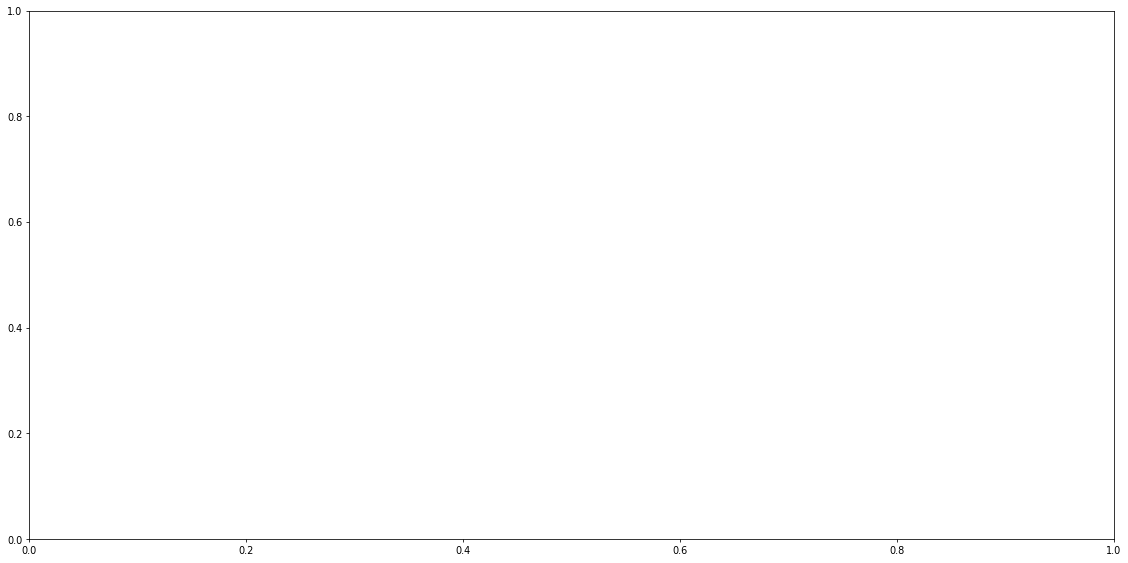

In [122]:
from FKMC.stats import bin_estimate_tau

f, ax = plt.subplots(1,1, figsize = (20,10))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

idx = slice(None,None,None)

y_ = Mf_moments[idx, i, 2]
auto_taus = np.array([series_tau(x) for x in y_[0]])
bin_taus = bin_estimate_tau(y_)

    ax.plot(Ts[idx], bin_taus[0], color = colors[i], label = f'bin N = {N}', marker = 'x')
    ax.plot(Ts[idx], auto_taus, color = colors[i], label = f'auto N = {N}', marker = 'o')
ax.legend()
ax.set(ylim = (0,200))

In [16]:
type(np.linspace(0,10))

numpy.ndarray

In [19]:
obs1 = get_data_2(Path('/data/users/tch14/slurm_runs/95035'))

looking in /data/users/tch14/slurm_runs/95035
job ids range from 0 to 299
missing jobs: set()

keys:  ['Ns', 'Ts', 'parameters', 'MCMC_params', 'logs', 'desc'] 

MCMC_params:  {'state': '...', 'N_steps': 1000000, 'N_burn_in': 10000, 'thin': 1000, 'logger': <FKMC.montecarlo.Eigenspectrum_IPR_all object at 0x7f1fc2cdf320>, 'proposal': <function p_multi_site_uniform_reflect at 0x7f1fc8c92ea0>, 'accept_function': <function perturbation_accept at 0x7f1fc8c94268>, 'warnings': True} 

MCMC Steps: 1000000 with thinning = 1000 for 1000 recorded steps
Slicing this with MCMC_slice = slice(None, None, 1)

T has (min, max, len) = [1.0, 2.0, 300], slicing by slice(None, None, 1) to get [1.0, 2.0, 300]

dir(d["logs"][0]) = ['A', 'Fc', 'Ff', 'IPRs', 'Mf_moments', 'N_cumulants', 'N_sites', 'N_steps', 'Nc', 'Nf', 'accept_rates', 'classical_accept_rates', 'eigenval_bins', 'eigenvals', 'last_state', 'powers', 'proposal_rates', 'return_vals', 'start', 'state', 'time', 'update']
Allocating space for the req

(array([93., 52., 95., 32., 16.,  7.,  3.,  0.,  1.,  1.]),
 array([ 2.7507503 ,  4.15745515,  5.56416001,  6.97086486,  8.37756972,
         9.78427457, 11.19097943, 12.59768428, 14.00438914, 15.41109399,
        16.81779885]),
 <a list of 10 Patch objects>)

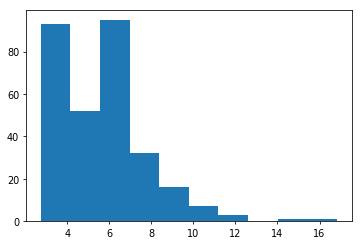

In [33]:
plt.hist(obs1.time.sum(axis = 0)/60/60)

In [26]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

cartesian_product(np.linspace(0,10,10), np.linspace(0,1,10))

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.11111111],
       [ 0.        ,  0.22222222],
       [ 0.        ,  0.33333333],
       [ 0.        ,  0.44444444],
       [ 0.        ,  0.55555556],
       [ 0.        ,  0.66666667],
       [ 0.        ,  0.77777778],
       [ 0.        ,  0.88888889],
       [ 0.        ,  1.        ],
       [ 1.11111111,  0.        ],
       [ 1.11111111,  0.11111111],
       [ 1.11111111,  0.22222222],
       [ 1.11111111,  0.33333333],
       [ 1.11111111,  0.44444444],
       [ 1.11111111,  0.55555556],
       [ 1.11111111,  0.66666667],
       [ 1.11111111,  0.77777778],
       [ 1.11111111,  0.88888889],
       [ 1.11111111,  1.        ],
       [ 2.22222222,  0.        ],
       [ 2.22222222,  0.11111111],
       [ 2.22222222,  0.22222222],
       [ 2.22222222,  0.33333333],
       [ 2.22222222,  0.44444444],
       [ 2.22222222,  0.55555556],
       [ 2.22222222,  0.66666667],
       [ 2.22222222,  0.77777778],
       [ 2.22222222,

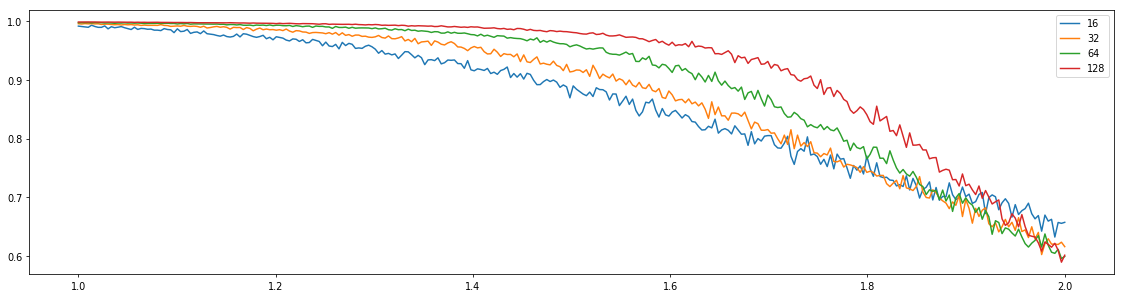

In [4]:
f, ax = plt.subplots(figsize = (20,5))
N_i = slice(2,None,None)
T_i = slice(200,None,None)

y = (obs1.Mf_moments[N_i, :, 2].mean(axis=-1))**2 / (obs1.Mf_moments[N_i, :, 4].mean(axis=-1))
for i, N in enumerate(obs1.Ns[N_i]):
    ax.plot(obs1.T, y[i], label = N)
ax.legend()

[-0.13289101  0.00767147  0.14442432]
[-0.12981937  0.007316    0.14079213]
[-0.12680228  0.00697809  0.13723632]
[-0.12366488  0.00664161  0.13354741]
[-0.12056164  0.00631948  0.12991239]
[-0.11779439  0.00603434  0.12669053]
[-0.11503133  0.00575869  0.12348335]
[-0.11254891  0.00551258  0.1206175 ]
[-0.10997688  0.00526759  0.11765366]
[-0.10741972  0.00503157  0.11471539]
[-0.10476748  0.00479636  0.11167483]
[-0.10244583  0.00459061  0.10902811]
[-0.1004167   0.00441055  0.1067265 ]
[-0.0982684   0.00422784  0.10429208]
[-0.09604975  0.0040464   0.101782  ]
[-0.09402259  0.00388096  0.09949908]
[-0.09185334  0.00371239  0.09705798]
[-0.08985386  0.00355866  0.09481652]
[-0.08792731  0.00341359  0.0926628 ]
[-0.08664349  0.00330883  0.09124174]
[-0.08525487  0.00320075  0.08970336]
[-0.0836617   0.00308514  0.0879348 ]
[-0.08176561  0.00295606  0.08582858]
[-0.0799914   0.00283692  0.08386388]
[-0.07819558  0.00271915  0.0818799 ]
[-0.0763175   0.0025998   0.07980918]
[-0.07486357

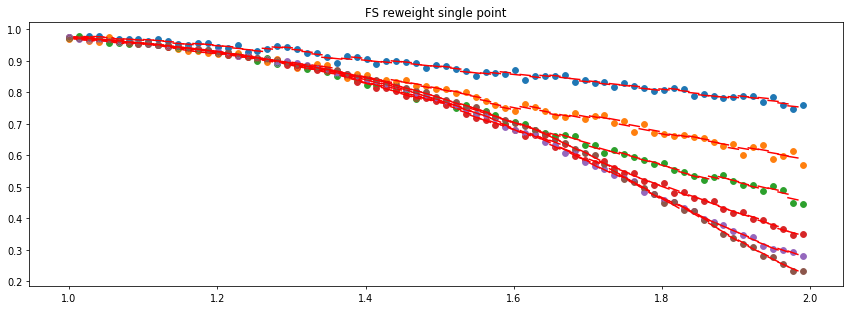

In [10]:
T_slice = slice(None, None, 4)        
obs = obs1

def interp_multi(Ts, Fs, Os, ax, m = 3):
    fs_guess = None
    grid = np.arange(-(m//2), (m//2) + 1, 1) #[-1,0,1], [-2,-1,0,1,2] etc
    for i in range(len(Ts))[m//2:-(m//2)]:
        try:
            ix = i + grid 
            new_Ts = np.linspace((Ts[i-1]+Ts[i])/2,(Ts[i]+Ts[i+1])/2, 10)

            reweighted_O, fs = FS_multi_reweight(new_betas = 1/new_Ts, betas = 1/Ts[ix], Fs = Fs[ix], Os = Os[ix])

            ax.plot(new_Ts, reweighted_O, color = 'r')
        except RuntimeError:
            pass

f, ax = plt.subplots(1, figsize = (15,5))
for N_slice, N in enumerate(obs1.Ns):
    
    T = obs.T[T_slice]
    Fs = obs.Ff[N_slice, T_slice] + obs.Fc[N_slice, T_slice]
    Os = obs.Mf_moments[N_slice, T_slice, 2, :]
    
    #print(Os.shape)

    y = Os.mean(axis=-1)
    yerr = Os.std(axis = -1)



    ax.plot(T, y, '.', label = 'Full data')
    ax.scatter(T, y, marker = 'o', label = 'Data used for interpolation')

    ax.set(
        title = 'FS reweight single point',
        #xlim = (1,1.2),
        )
    interp_multi(T, Fs, Os, ax)